In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configuration

### Inputs

In [2]:
process_out_dir = '../../01_process/out/'
train_out_dir = '../../02_train/out/'

# data, primarily for the ice flags
train_data_fpath = process_out_dir + 'train_data.npz'
valid_data_fpath = process_out_dir + 'valid_data.npz'

train_predictions_fpath = train_out_dir + 'limitted_lstm_train_preds.npy'
valid_predictions_fpath = train_out_dir + 'limitted_lstm_valid_preds.npy'

eval_metrics_fpath = '../out/eval_metrics.npz'

mapping_reference = "../../01_process/in/MN_ice/raw_data_from_DNR/lake_ice_id_spreadsheet.xlsx"

# Import data

In [3]:
# Import both development partitions
train_data = np.load(train_data_fpath, allow_pickle = True)
valid_data = np.load(valid_data_fpath, allow_pickle = True)

# Extract everything from training partition
train_x = train_data['x']
train_y = train_data['y']
train_dates = train_data['dates']
train_DOW = train_data['DOW']
train_variables = train_data['features']

# Extract everything from validation partition
valid_x = valid_data['x']
valid_y = valid_data['y']
valid_dates = valid_data['dates']
valid_DOW = valid_data['DOW']
valid_variables = valid_data['features']

In [4]:
train_predictions = np.load(train_predictions_fpath)
valid_predictions = np.load(valid_predictions_fpath)

In [5]:
# Programmatically identify process-based ice flag data
ice_var_idx = int(np.argwhere(train_variables == 'ice'))
assert valid_variables[ice_var_idx] == 'ice'

In [6]:
eval_metrics = np.load(eval_metrics_fpath, allow_pickle = True)

# Plot some simple time series

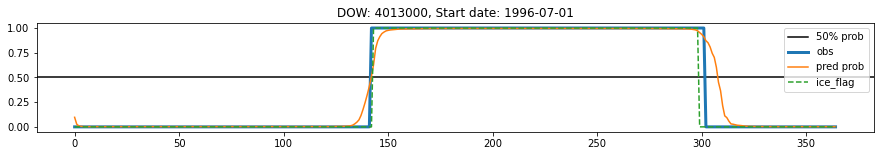

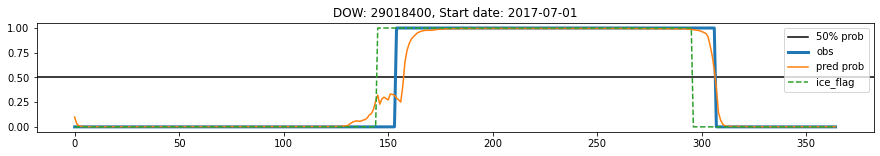

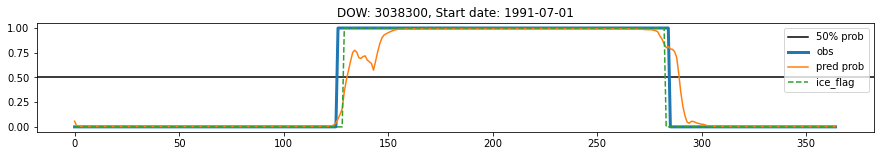

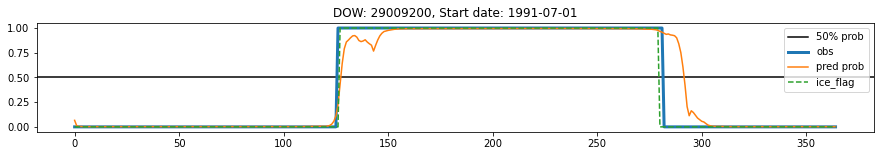

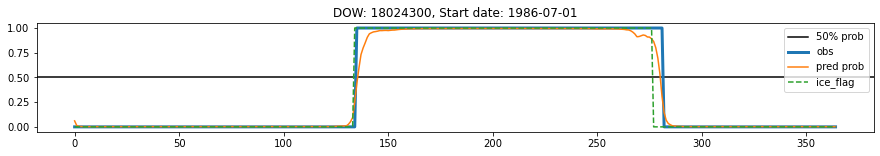

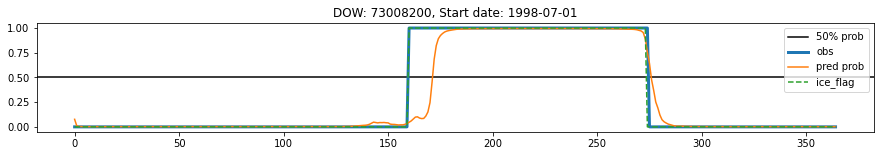

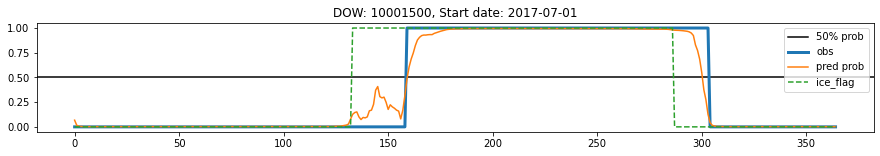

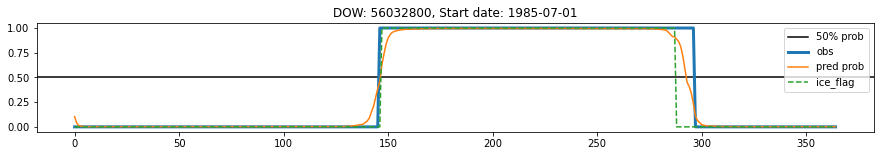

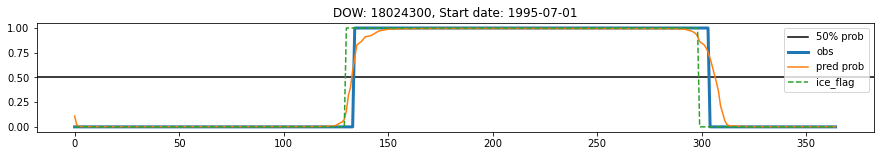

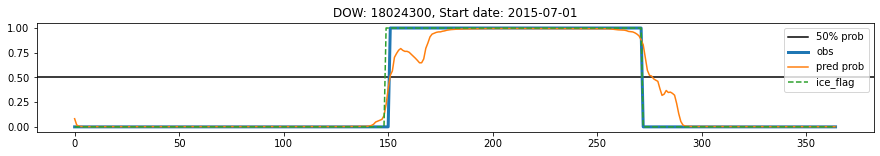

In [7]:
# Seed to view the same ones each time
np.random.seed(123)

# 10 random time series plots
# Includes:
#   Observation
#   Prediction
#   PB ice flag
#   50% probability line
#   Date and DOW of time series
for i in range(10):
    rand_i = np.random.choice(valid_predictions.shape[0])

    plt.figure(figsize = (15, 2))
    plt.axhline(0.5, label = '50% prob', color = 'black')
    plt.plot(valid_y[rand_i, :], label = 'obs', linewidth = 3)
    plt.plot(valid_predictions[rand_i, :, 0], label = 'pred prob')
    plt.plot(valid_x[rand_i, :, ice_var_idx], label = 'ice_flag', linestyle = '--')
    plt.title('DOW: ' + str(valid_DOW[rand_i]) + ', Start date: ' + valid_dates[rand_i][0])
    plt.legend();

# Spatial distribution

In [8]:
# Read in the MN lake metadata, focusing on coordiantes and lake size
lat_lon_ref_df = pd.read_excel(mapping_reference,
                               usecols=['dow num', 'lat', 'long', 'acres'])
lat_lon_ref_df = lat_lon_ref_df.rename(columns = {'dow num':'DOW'})

# Merge that information with the validation set DOWs
seq_DOWs = pd.DataFrame({'DOW':valid_DOW})
mapping_df = seq_DOWs.merge(lat_lon_ref_df, on='DOW', how = 'left')

In [9]:
# Assign all the errors to that newly merged dataframe
# (both are sorted by validation set DOW)
mapping_df['flag_error_ice_on'] = eval_metrics['flag_error_ice_on']
mapping_df['flag_error_ice_off'] = eval_metrics['flag_error_ice_off']
mapping_df['flag_error_dur']  = eval_metrics['flag_error_dur'] 
mapping_df['pred_error_ice_on']  = eval_metrics['pred_error_ice_on'] 
mapping_df['pred_error_ice_off'] = eval_metrics['pred_error_ice_off'] 
mapping_df['pred_error_dur'] = eval_metrics['pred_error_dur']

In [10]:
def map_error(error_col_suffix, jitter):
    # Craft the two column names
    process_based_col = 'flag_' + error_col_suffix
    new_model_col = 'pred_' + error_col_suffix
    
    # Set the colors to map to the same values
    cmap_extreme = np.max(np.abs([mapping_df[new_model_col].min(),
                                  mapping_df[new_model_col].max()]))
    
    # Configure a 2-plot arangement
    fig, ax = plt.subplots(1, 3, figsize = (13, 6), gridspec_kw={'width_ratios': [6, 6, 0.5]})
    
    # Create the spatial jitter values (same for both subplots)
    lat_jitter = np.random.normal(loc = 0, scale = jitter, size = mapping_df.shape[0])
    lon_jitter = np.random.normal(loc = 0, scale = jitter, size = mapping_df.shape[0])
    
    # Plot ice flag errors with spatial jitter
    # Size and color are mapped to error
    ax[0].set_title("Process-based Ice Flags")
    ax[0].scatter(mapping_df['long'] + lon_jitter,
                  mapping_df['lat'] + lat_jitter,
                  s = np.abs(mapping_df[process_based_col]*3),
                  marker = 'o',
                  cmap = 'BrBG',
                  vmin = -1*cmap_extreme,
                  vmax = cmap_extreme,
                  c = mapping_df[process_based_col])
    
    # Plot new prediction errors with spatial jitter
    # Size and color are mapped to error
    ax[1].set_title("New Model Predictions")
    im = ax[1].scatter(mapping_df['long'] + lon_jitter,
                  mapping_df['lat'] + lat_jitter,
                  s = np.abs(mapping_df[new_model_col]*3),
                  marker = 'o',
                  cmap = 'BrBG',
                  vmin = -1*cmap_extreme,
                  vmax = cmap_extreme,
                  c = mapping_df[new_model_col])
    
    # Color legend
    fig.colorbar(im, label = 'Days', cax = ax[2]);

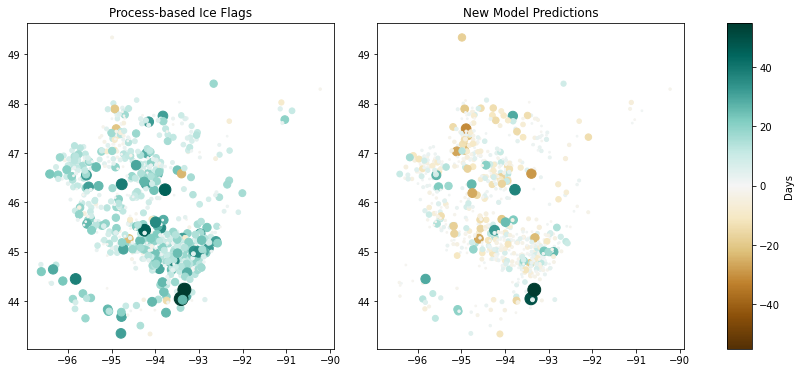

In [11]:
map_error('error_ice_on', 0.2)

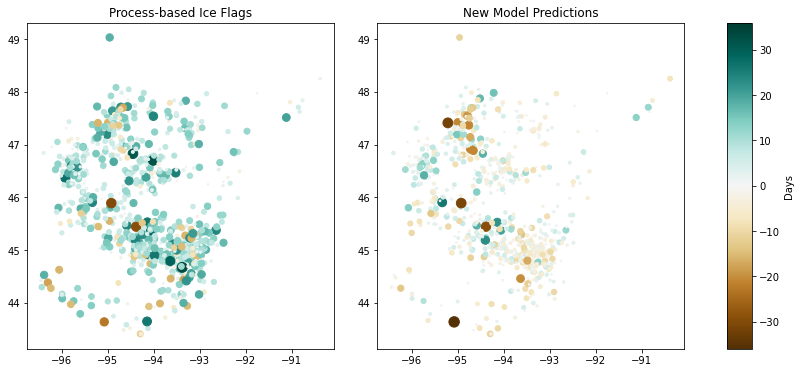

In [12]:
map_error('error_ice_off', 0.2)

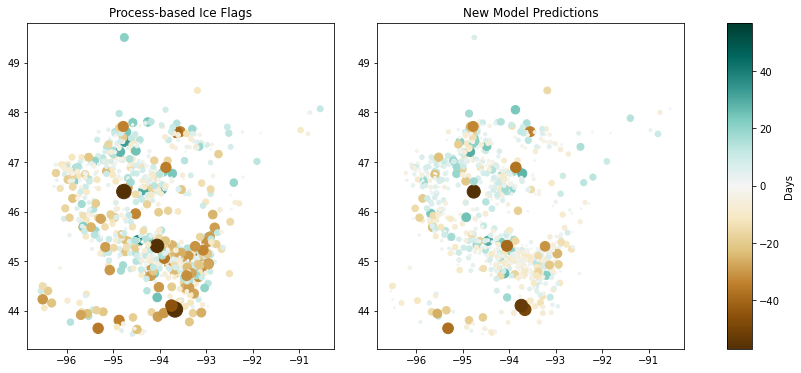

In [13]:
map_error('error_dur', 0.2)

# TO DO:

Add some more evaluation for how error changes other lake characteristics: depth, area, etc